In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

df = pd.read_csv("./data/test1/ping.csv")

print(df)

: 

In [ ]:

# Hardcoded IP -> Name mapping
ip_map = {
    "45.77.229.242": "GB-London",
    "62.154.179.86": "DE-Berlin",
    "194.156.155.241": "ES-Madrid",
    "194.230.35.117": "CH-Zürich",
    "193.46.104.17": "AT-Vienna",
    "185.32.189.249": "PT-Lisbon",
    "213.135.49.134": "PL-Warsaw",
    "51.159.68.135": "FR-Paris",
    "185.78.84.3": "TR-Istanbul",
    "185.157.208.248": "GR-Athens"
}

# Clean data
df['src_addr'] = df['src_addr'].str.strip()
df['dst_addr'] = df['dst_addr'].str.strip()
df = df[df['avg'] > 0]

# Make symmetric
df_swapped = df.rename(columns={'src_addr':'dst_addr', 'dst_addr':'src_addr'})
df_symmetric = pd.concat([df, df_swapped], ignore_index=True)

# Aggregate duplicates
agg_df = df_symmetric.groupby(['src_addr', 'dst_addr'])['avg'].mean().reset_index()

# Map IPs to names
agg_df['src_addr'] = agg_df['src_addr'].map(ip_map)
agg_df['dst_addr'] = agg_df['dst_addr'].map(ip_map)

# Get all unique names
all_names = sorted(set(agg_df['src_addr']).union(agg_df['dst_addr']))

# Full Cartesian product of names
full_pairs = pd.DataFrame(list(product(all_names, all_names)), columns=['src_addr', 'dst_addr'])

# Merge with aggregated data and fill missing with 0
full_df = pd.merge(full_pairs, agg_df, on=['src_addr', 'dst_addr'], how='left').fillna(0)

# Pivot for heatmap
heatmap_data = full_df.pivot(index='src_addr', columns='dst_addr', values='avg')

print(heatmap_data.head())

dst_addr   CH-Zürich  DE-Berlin  ES-Madrid   FR-Paris  GB-London  GR-Athens  \
src_addr                                                                      
CH-Zürich   0.000000  21.246789  26.666942  17.652651  26.846172  41.617591   
DE-Berlin  21.246789   0.000000  36.181896  21.282752  22.295961  48.145862   
ES-Madrid  26.666942  36.181896   0.000000  27.481487  26.002411  62.944298   
FR-Paris   17.652651  21.282752  27.481487   0.000000   9.734107  47.043224   
GB-London  26.846172  22.295961  26.002411   9.734107   0.000000  51.430447   

dst_addr   PL-Warsaw  PT-Lisbon  TR-Istanbul  
src_addr                                      
CH-Zürich  26.280572  44.246431    48.649828  
DE-Berlin  32.131557  42.684284    42.635036  
ES-Madrid  76.258033  10.566032    53.653275  
FR-Paris   29.403406  35.942165    44.484077  
GB-London  26.794499  32.323801    50.826318  


Text(70.72222222222221, 0.5, 'Source Address')

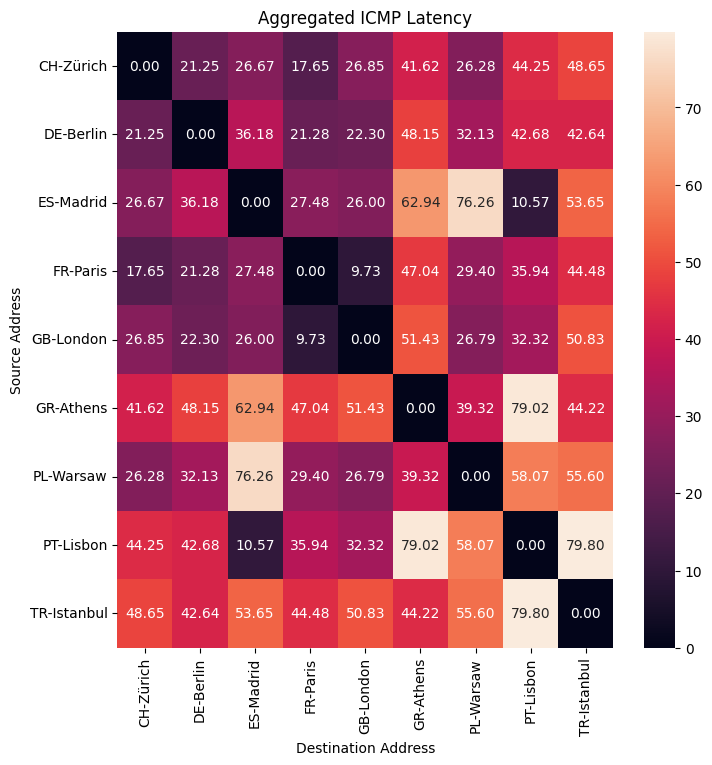

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="rocket")
plt.title("Aggregated ICMP Latency")
plt.xlabel("Destination Address")
plt.ylabel("Source Address")